In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

2025-04-16 19:19:53.065253: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744831193.290728      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744831193.352842      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [3]:
print("Training data shape:", X_train.shape)  # (50000, 32, 32, 3)
print("Test data shape:", X_test.shape)      # (10000, 32, 32, 3)
print("Class labels:", np.unique(y_train))   # [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)
Class labels: [0 1 2 3 4 5 6 7 8 9]


In [6]:
def preprocess_data(X, y):
    X = X.astype('float32') / 255.0  # Normalize to [0, 1]
    y = to_categorical(y, num_classes=10)  # One-hot encoding
    return X, y


In [7]:

X_train, y_train = preprocess_data(X_train, y_train)
X_test, y_test = preprocess_data(X_test, y_test)

In [8]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam

def build_cifar10_model():
    weight_decay = 1e-4
    alpha = 0.1  # LeakyReLU slope

    model = models.Sequential()

    # Data Augmentation
    model.add(layers.Input(shape=(32, 32, 3)))
    model.add(layers.Rescaling(1./255))
    model.add(layers.RandomFlip("horizontal"))
    model.add(layers.RandomRotation(0.1))
    model.add(layers.RandomZoom(0.1))

    # Block 1
    model.add(layers.Conv2D(32, (3, 3), padding='same',
                            kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU(alpha=alpha))
    model.add(layers.Conv2D(32, (3, 3), padding='same',
                            kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU(alpha=alpha))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Block 2
    model.add(layers.Conv2D(64, (3, 3), padding='same',
                            kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU(alpha=alpha))
    model.add(layers.Conv2D(64, (3, 3), padding='same',
                            kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU(alpha=alpha))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))

    # Block 3
    model.add(layers.Conv2D(128, (3, 3), padding='same',
                            kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU(alpha=alpha))
    model.add(layers.Conv2D(128, (3, 3), padding='same',
                            kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU(alpha=alpha))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.4))

    # Fully connected
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU(alpha=alpha))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(10, activation='softmax'))  # CIFAR-10 has 10 classes

    return model


In [9]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
def lr_scheduler(epoch, lr):
    if epoch % 20 == 0 and epoch != 0:
        return lr * 0.1
    return lr

lr_callback = LearningRateScheduler(lr_scheduler)

In [11]:

history = model.fit(X_train, y_train, 
                    epochs=20, 
                    batch_size=64, 
                    validation_data=(X_test, y_test),
                    callbacks=[lr_callback],
                    verbose=1)


Epoch 1/20


I0000 00:00:1744831437.869198      91 service.cc:148] XLA service 0x783590002b10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744831437.869910      91 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744831438.632715      91 cuda_dnn.cc:529] Loaded cuDNN version 90300


 27/782 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1535 - loss: 3.4369 

I0000 00:00:1744831444.868402      91 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.3615 - loss: 2.1260 - val_accuracy: 0.5971 - val_loss: 1.2463 - learning_rate: 0.0010
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6224 - loss: 1.1590 - val_accuracy: 0.6983 - val_loss: 0.9789 - learning_rate: 0.0010
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6881 - loss: 0.9880 - val_accuracy: 0.7415 - val_loss: 0.8649 - learning_rate: 0.0010
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7274 - loss: 0.8990 - val_accuracy: 0.7436 - val_loss: 0.8757 - learning_rate: 0.0010
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7597 - loss: 0.8253 - val_accuracy: 0.7764 - val_loss: 0.7923 - learning_rate: 0.0010
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7828 - loss: 0.7782 - val_accuracy: 0.7828 - val_loss: 0.8051 - learning_rate: 0.0010
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7923 - loss: 0.7689 - val_accur

In [12]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc*100:.2f}%")

Test Accuracy: 82.30%


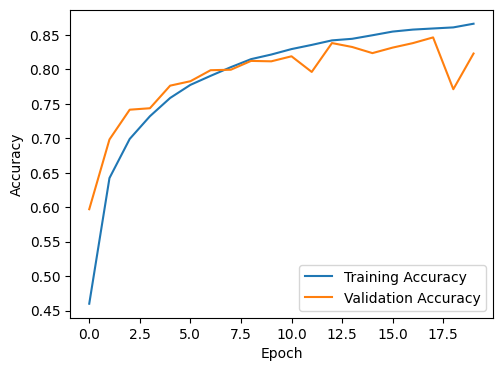

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

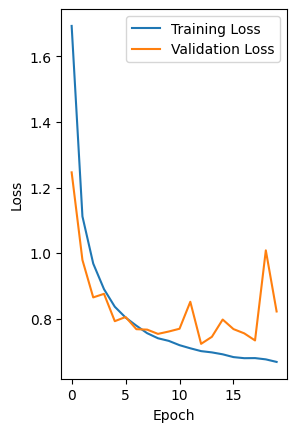

In [14]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


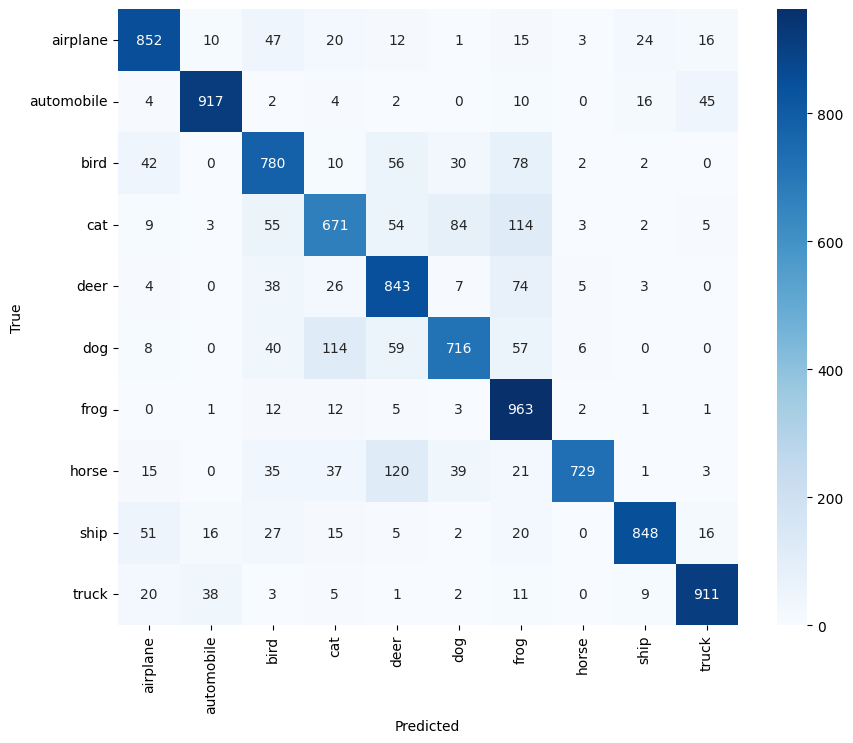

In [15]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [16]:
print(classification_report(y_true, y_pred_classes, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.85      0.85      0.85      1000
  automobile       0.93      0.92      0.92      1000
        bird       0.75      0.78      0.77      1000
         cat       0.73      0.67      0.70      1000
        deer       0.73      0.84      0.78      1000
         dog       0.81      0.72      0.76      1000
        frog       0.71      0.96      0.82      1000
       horse       0.97      0.73      0.83      1000
        ship       0.94      0.85      0.89      1000
       truck       0.91      0.91      0.91      1000

    accuracy                           0.82     10000
   macro avg       0.83      0.82      0.82     10000
weighted avg       0.83      0.82      0.82     10000

